# Práctica 3: Paseos aleatorios II
## Antonio Sevilla Sastre

### Ejercicio 1

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import random
import math

In [2]:
random.seed(1000)

In [3]:
def Z_gen(alpha, cte):
    """
    este método genera una variable aleatoria distribuida como la razón de potencias descrita    
    """
    p = random.random()
    k = 1
    s = 0
    while s < p:
        s += 2*cte*math.pow(k, -1-alpha)
        k += 1
    return k-1

In [4]:
def galton_cuantico(num_pasos, alpha):
    """
    este método devuelve una simulación de paseo aleatorio con saltos como lista de posiciones   
    """
    situacion_bola = np.zeros(num_pasos + 1, dtype=int)
    # calculammos la constante que acompaña a la razón de potencias
    riemansum = 0
    for k in range(1, num_pasos):
        riemansum += math.pow(k, -1 - alpha)
    cte = 1/(2*riemansum)
    # generamos la variable aleatoria
    for j in range(1, num_pasos + 1):
        valor_aleatorio = random.random()
        # esta se transforma en la Z pedida mediante el método Z_gen, se le suma a la posición del paso anterior y se añade a la lista
        while valor_aleatorio == 0.5:
                valor_aleatorio = random.random()
        if valor_aleatorio > 0.5:
            situacion_bola[j]=situacion_bola[j-1] + Z_gen(alpha, cte)
        else:
            situacion_bola[j]=situacion_bola[j-1] - Z_gen(alpha, cte)
    return list(situacion_bola)

In [5]:
galton_cuantico(10, 0.5)

[0, 2, 1, -1, 0, 1, 0, 1, 0, 1, -2]

In [6]:
def galton_cuantico_matriz_plot(num_bolas, num_pasos, alpha):
    """
    representa sobre una misma gráfica tantas realizaciones como indique el valor de num_bolas que tienen tantos pasos como indique el valor de num_pasos 
    """
    for k in range(num_bolas):
        # en cada iteración generamos una simulación y la representamos contra el vector tiempo en pasos
        plt.plot(list(range(num_pasos + 1)), galton_cuantico(num_pasos,alpha))
        plt.ylabel("Posición"); plt.xlabel("Paso")
        plt.legend(["num_pasos = " + str(num_pasos), "alpha = " + str(alpha)])
    plt.show()

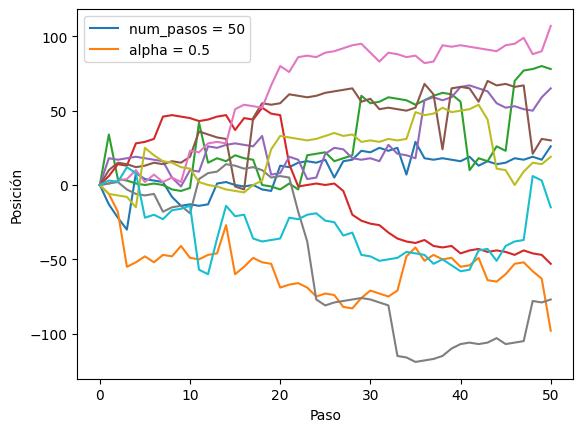

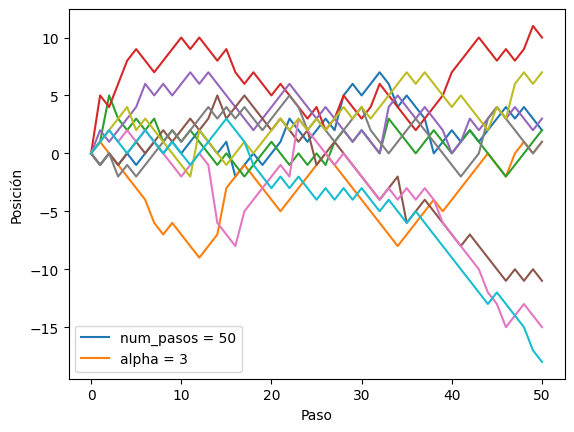

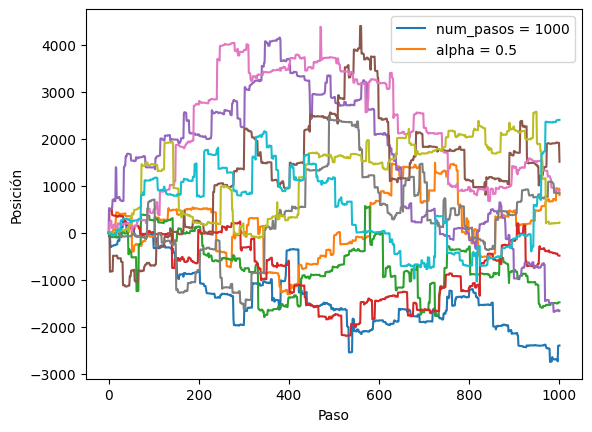

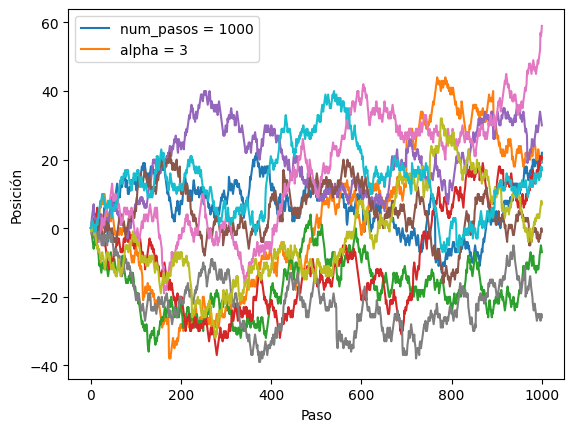

In [7]:
galton_cuantico_matriz_plot(10,50,0.5)
galton_cuantico_matriz_plot(10,50,3)
galton_cuantico_matriz_plot(10,1000,0.5)
galton_cuantico_matriz_plot(10,1000,3)

### Ejercicio 2

In [8]:
def cambio(actual, alpha, truncamiento, cte):
    """   
    este método devuelve el vector de longitud truncamiento que especifica la distribución de probabilidad del siguiente instante de tiempo dado el del instante previo
    considerando los saltos mencionados en el Ejercicio 1
    """
    result = []
    for a in range(2*truncamiento+1):
        result.append(0)
        for b in range(2*truncamiento+1):       
            if a != b:
                result[a] += cte*math.pow(abs(a-b), -1-alpha)*actual[b]
    return result

In [9]:
def gif_iterativo_saltos(num_pasos, h, alpha, truncamiento, frec):
    """  
    este método calcula la distribución de probabilidad de num_pasos pasos
    se truncan las ubicaciones positivas o negativas más grandes que truncamiento
    genera un gif con las probabilidades de cada ubicación
    frec indica la frecuencia con la que se considera el frame la posición generada oara el gif
    """
    actual, siguiente, lista_plots = np.zeros(2*truncamiento+1), np.zeros(2*truncamiento+1), []
    actual[truncamiento] = 1
    x = np.array(range(-truncamiento, truncamiento+1))*h
    # calculamos la suma de riemman
    riemansum = 0
    for k in range(1, len(actual)):
        riemansum += math.pow(k, -1 - alpha)
    cte = 1/(2*riemansum)
    # realizamos los cambios num_pasos iteraciones
    for paso in range(1, num_pasos + 1):
        auxiliar = []
        for i in siguiente:
            auxiliar.append(i)
        siguiente = cambio(actual, alpha, truncamiento, cte)
        actual = []
        for j in auxiliar:
            actual.append(j)
        # solo consideramos ciertos frames
        if paso%frec == 0 and paso%2 == 0:
            actual_plot = np.array(actual)/h
            plt.xlim(-truncamiento*h, truncamiento*h)
            plt.ylim(0,1.1)
            plt.plot(x,actual_plot, "b.")
            plt.savefig(str(paso)+'saltos.png')
            plt.legend(["p^n_i / h"],fontsize = 12, loc='upper right')
            plt.xlabel("ih")
            plt.show()
            lista_plots.append(str(paso)+'saltos.png')
            with imageio.get_writer('saltosgif.gif', mode='I') as writer:
                for filename in lista_plots:
                    image = imageio.imread(filename)
                    writer.append_data(image)

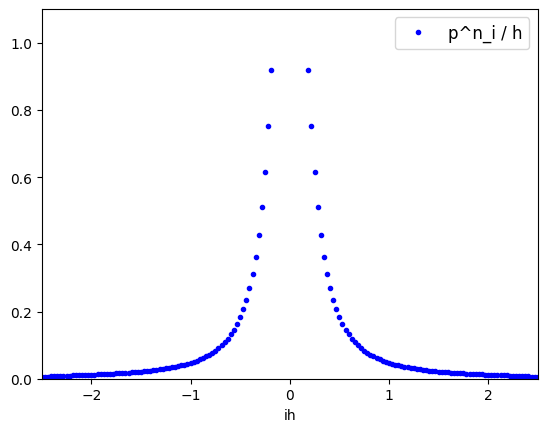

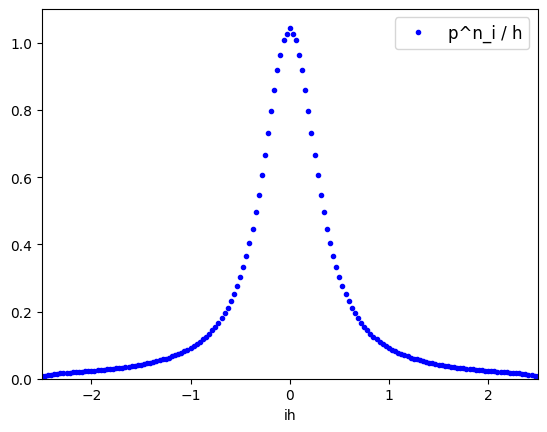

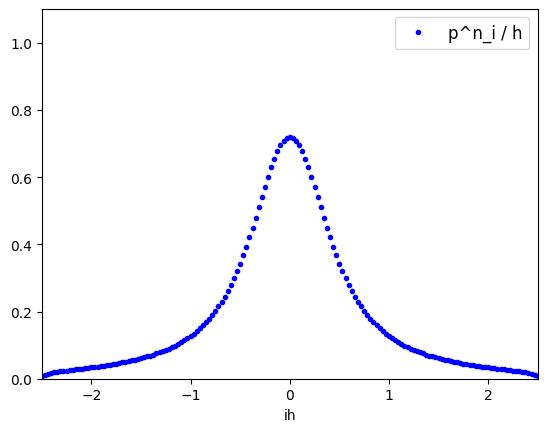

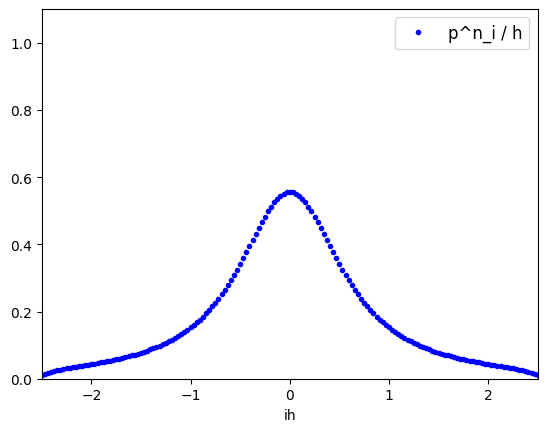

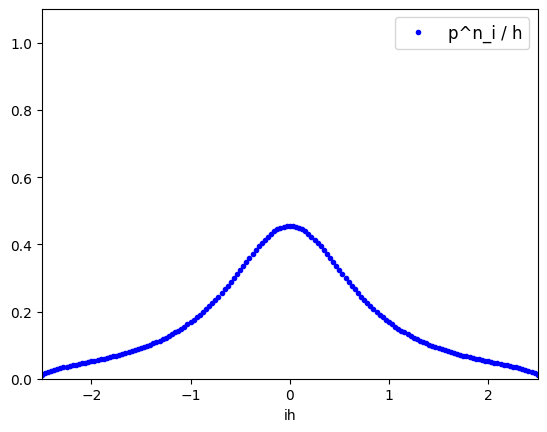

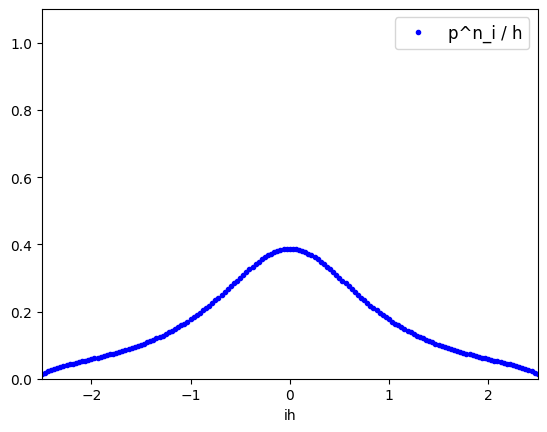

In [10]:
gif_iterativo_saltos(60, 2**-5, 1, 80, 5)

In [11]:
def final_saltos(num_pasos,h, alpha, truncamiento):
    """
    este método devuelve el cálculo numérico de la probabilidad de cada punto una vez finalizan los num_pasos
    así como las abscisas de la representación escaladas con respecto a h
    """
    actual, siguiente, = np.zeros(2*truncamiento+1), np.zeros(2*truncamiento+1)
    actual[truncamiento] = 1
    x = np.array(range(-truncamiento, truncamiento+1))*h
    riemansum = 0
    for k in range(1, len(actual)):
        riemansum += math.pow(k, -1 - alpha)
    cte = 1/(2*riemansum)
    for paso in range(1, num_pasos+1):
        auxiliar = []
        for i in siguiente:
            auxiliar.append(i)
        siguiente = cambio(actual, alpha, truncamiento, cte)
        actual = []
        for j in auxiliar:
            actual.append(j)
    return {"array_p_i": actual, "array_ih": x}

Al truncar se considera cada vez menos masa de probabilidad porque se producen saltos fuera de los $i$ considerados.


Además, se obvian los posibles saltos realizados desde los $i$ no considerados. Esto afecta significativamente más a los extremos, que se "hinchan" erróneamente.

En las colas, el sesgo se distribuye de la siguiente manera:

In [12]:
def analisis_colas(num_pasos,h, alpha, truncamiento, len_cola, end_cola):
    """ 
    este método representa en escala logarítmica las probabilidades en la cola final
    así como la regresión lineal realizada sobre últimos len_cola puntos de la cola
    no se tienen en cuenta los últimos end_cola de estos para la regresión
    """
    array_p_i, array_ih = final_saltos(num_pasos,h, alpha, truncamiento)["array_p_i"], final_saltos(num_pasos,h, alpha, truncamiento)["array_ih"]
    cola_p_i, cola_ih = array_p_i[- len_cola: - end_cola], array_ih[ - len_cola: - end_cola]
    plt.plot(np.log(array_ih),np.log(array_p_i), "bo")
    plt.plot(np.log(cola_ih),np.log(cola_p_i), "go")
    fit = np.polyfit(np.log(cola_ih),np.log(cola_p_i), 1)
    plt.plot(np.log(cola_ih), fit[1] + fit[0]*np.log(cola_ih), "r-")
    plt.legend(["log(p^n_i / h)", "puntos considerados para la regresión", "recta de regresión"])
    plt.xlabel("log(ih)")
    plt.show()

C:\Users\Antonio\AppData\Local\Temp\ipykernel_13720\339173567.py:9: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(array_ih),np.log(array_p_i), "bo")
C:\Users\Antonio\AppData\Local\Temp\ipykernel_13720\339173567.py:9: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(array_ih),np.log(array_p_i), "bo")


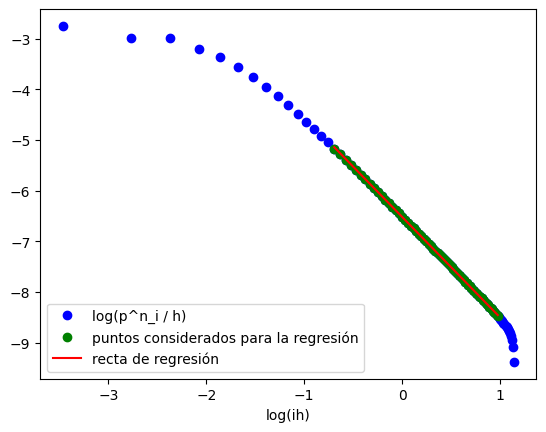

In [13]:
analisis_colas(10, 2**-5, 1, 100, 85, 15)
# el error del que advierte python se produce por intentarrepresentar logarítimicamente valores negativos o nulos, pero se plotean los válidos

### Ejercicio 4

Se puede observar que $$\,p_i^{n+1} =  \frac{1}{2}p_{i-1}^{n} + \frac{1}{2}p_{i+1}^{n} $$ con lo que se puede llegar a la relación

$$\frac{p_i^{n+1} - p_i^{n}}{\tau} = \frac{h^2 (p_{i-1}^{n} + p_{i+1}^{n} - 2p_{i}^{n})}{2\tau h^2}$$

Fijando $\tau = h$ la expresión es muy parecida al método de Euler de la siguiente ecuación de calor unidimensional

$$\frac{\partial u}{\partial t} = \frac{1}{2} \frac{\partial ^2 u}{\partial ^2 t}$$

cuya solución con $u(0,x) = \delta_0$ es la función de densidad de la normal centrada en 0 y varianza t.

La transformada de Fourier de $-\frac{\partial ^2 u}{\partial ^2 t}$ es $|\omega|^2 \hat{u}(\omega)$

En general la transformada del Laplaciano fraccionario es $D|\omega|^\alpha \hat{u}(\omega)$ .

Llamando $\alpha = 2s$ y construimos

$$(-\triangle)^s u(x) = - \frac{C_\alpha}{2}\int_{-\infty}^{\infty} \frac{u(x-y)+ u(x+y)-2u(x)}{|z|^{1+\alpha}}dz$$

tomando cierta constante $C_\alpha$ de manera que $(-\triangle)^s u(x)$ sea la antintransformada de Fourier de $|\omega|^\alpha \hat{u}(\omega)$.

Dado $\alpha = 1$ ó $s = \frac{1}{2}$ podemos construir la aproximación adecuada como la antitransformada de Fourier de $e^{-t|\omega|}$, cuyo valor explícito es

$$\frac{t}{\pi\,(t^2 + u^2)}$$

In [14]:
def gif_iterativo_saltos_comparado(num_pasos,h, alpha, truncamiento, frec, y_lim):
    """
    ligera modificación de la función gif_iterativo_saltos que junto a lo que este representaba añade la función estimada
    """
    actual, siguiente, lista_plots = np.zeros(2*truncamiento+1), np.zeros(2*truncamiento+1), []
    actual[truncamiento] = 1
    x = np.array(range(-truncamiento, truncamiento+1))*h
    riemansum = 0
    for k in range(1, len(actual)):
        riemansum += math.pow(k, -1 - alpha)
    cte = 1/(2*riemansum)
    for paso in range(1, num_pasos):
        auxiliar = []
        for i in siguiente:
            auxiliar.append(i)
        siguiente = cambio(actual, alpha, truncamiento, cte)
        actual = []
        for j in auxiliar:
            actual.append(j)
        if paso%frec == 0 and paso%2 == 0:
            actual_plot = np.array(actual)/h
            plt.xlim(-truncamiento*h, truncamiento*h)
            plt.ylim(0,y_lim)
            plt.plot(x,actual_plot, "bo")
            plt.xlabel("ih")
            ################# incluimos la representación de la aproximación teórica
            K = []
            for posible in x:
                K.append((1/math.pi) * (paso-1)*h**alpha / (posible**2 + ((paso-1)*h**alpha)**2))
            plt.plot(x, K, "orange")
            plt.legend(["p^n_i / h", "K_(1/2)"],fontsize = 12, loc='upper right')
            #################
            plt.savefig(str(paso)+'saltos.png')
            lista_plots.append(str(paso)+'saltos.png')
            plt.show()
            with imageio.get_writer('saltoscomparadogif.gif', mode='I') as writer:
                for filename in lista_plots:
                    image = imageio.imread(filename)
                    writer.append_data(image)

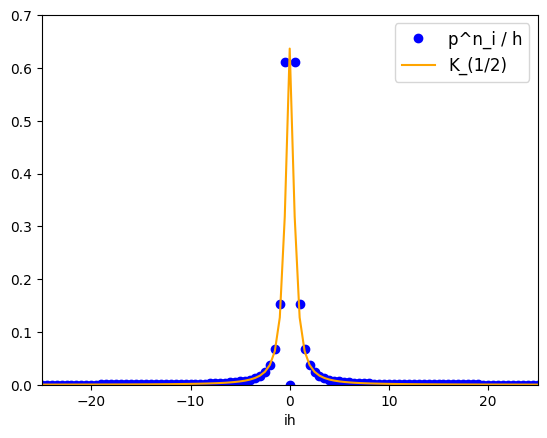

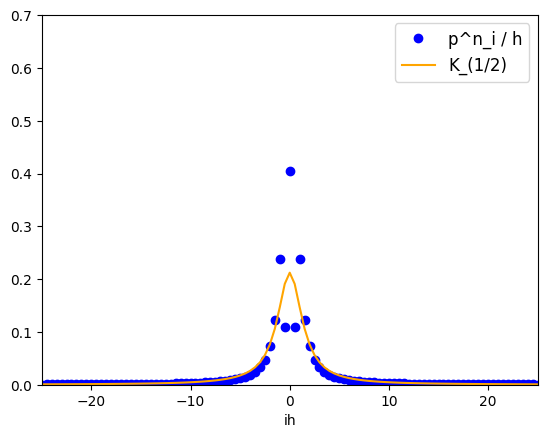

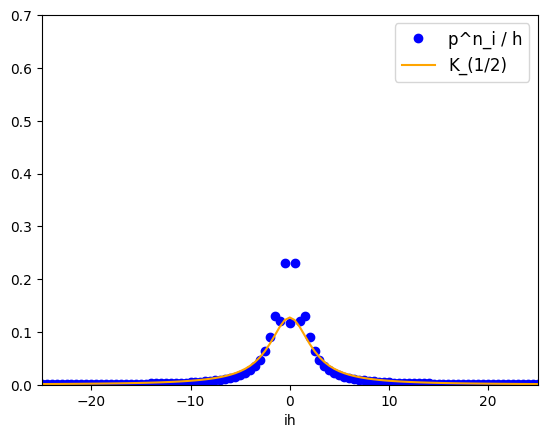

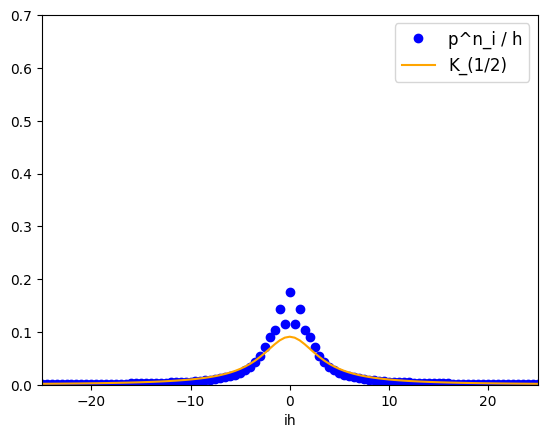

In [15]:
gif_iterativo_saltos_comparado(10, 0.5, 1, 50, 1, 0.7)